In [21]:
!pip install torch matplotlib seaborn tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [22]:
sentences = [
    "I love machine learning",
    "Transformers are powerful models",
    "Attention is all you need",
    "PyTorch makes building models easy",
    "Deep learning is fun",
    "Neural networks can learn patterns",
    "We can visualize attention",
    "Mini transformers are educational",
    "Sequence modeling is important",
    "Let's build a simple transformer"
]

# Build vocabulary
tokens = [word.lower() for s in sentences for word in s.split()]
vocab = sorted(list(set(tokens)))
vocab_size = len(vocab)
print(f"Vocab ({vocab_size} words): {vocab}")

stoi = {w:i for i,w in enumerate(vocab)}
itos = {i:w for i,w in stoi.items()}


Vocab (36 words): ['a', 'all', 'are', 'attention', 'build', 'building', 'can', 'deep', 'easy', 'educational', 'fun', 'i', 'important', 'is', 'learn', 'learning', "let's", 'love', 'machine', 'makes', 'mini', 'modeling', 'models', 'need', 'networks', 'neural', 'patterns', 'powerful', 'pytorch', 'sequence', 'simple', 'transformer', 'transformers', 'visualize', 'we', 'you']


In [23]:
max_len = max(len(s.split()) for s in sentences)

def tokenize(sentence):
    token_ids = [stoi[w.lower()] for w in sentence.split()]
    # Pad with zeros if shorter than max_len
    token_ids += [0]*(max_len - len(token_ids))
    return token_ids

tokenized = torch.tensor([tokenize(s) for s in sentences])  # shape: (batch, seq_len)
print("Tokenized sentences:\n", tokenized)

# Embedding
embed_dim = 16
embedding = nn.Embedding(vocab_size, embed_dim)
x = embedding(tokenized)  # shape: (batch, seq_len, embed_dim)
print("Embedded shape:", x.shape)


Tokenized sentences:
 tensor([[11, 17, 18, 15,  0],
        [32,  2, 27, 22,  0],
        [ 3, 13,  1, 35, 23],
        [28, 19,  5, 22,  8],
        [ 7, 15, 13, 10,  0],
        [25, 24,  6, 14, 26],
        [34,  6, 33,  3,  0],
        [20, 32,  2,  9,  0],
        [29, 21, 13, 12,  0],
        [16,  4,  0, 30, 31]])
Embedded shape: torch.Size([10, 5, 16])


In [24]:
def get_positional_encoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)
    for pos in range(seq_len):
        for i in range(0, d_model, 2):
            pe[pos, i] = np.sin(pos / (10000 ** ((2*i)/d_model)))
            if i+1 < d_model:
                pe[pos, i+1] = np.cos(pos / (10000 ** ((2*i)/d_model)))
    return pe

pe = get_positional_encoding(max_len, embed_dim)
x = x + pe  # Add positional encoding


In [25]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=2):
        super(SelfAttention, self).__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv_proj = nn.Linear(embed_dim, embed_dim*3)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size, seq_len, embed_dim = x.shape
        qkv = self.qkv_proj(x)  # (batch, seq_len, 3*embed_dim)
        q, k, v = qkv.chunk(3, dim=-1)

        # Split into heads
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1,2)

        # Scaled Dot-Product Attention
        scores = torch.matmul(q, k.transpose(-2,-1)) / np.sqrt(self.head_dim)  # (batch, heads, seq_len, seq_len)
        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, v)  # (batch, heads, seq_len, head_dim)

        # Concatenate heads
        out = out.transpose(1,2).contiguous().view(batch_size, seq_len, embed_dim)
        out = self.out_proj(out)
        return out, attn


In [26]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads=2, ff_hidden=32):
        super(TransformerEncoderBlock, self).__init__()
        self.attn = SelfAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_hidden),
            nn.ReLU(),
            nn.Linear(ff_hidden, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_out, attn_weights = self.attn(x)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        return x, attn_weights


In [27]:
encoder = TransformerEncoderBlock(embed_dim, num_heads=2)
contextual_embeddings, attn_weights = encoder(x)
print("Final contextual embeddings shape:", contextual_embeddings.shape)


Final contextual embeddings shape: torch.Size([10, 5, 16])


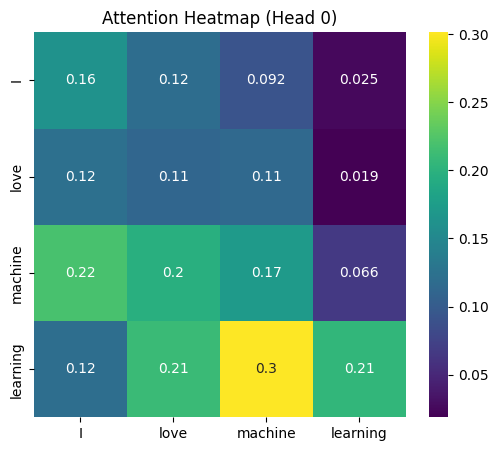

In [28]:
sentence_idx = 0
words = sentences[sentence_idx].split()
attn_matrix = attn_weights[0,0,:len(words), :len(words)].detach().numpy()  # first head

plt.figure(figsize=(6,5))
sns.heatmap(attn_matrix, xticklabels=words, yticklabels=words, cmap='viridis', annot=True)
plt.title("Attention Heatmap (Head 0)")
plt.show()
